> 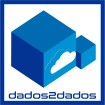



# Desafio Dados2Dados: Consumindo API de tempo e temperatura com Python e SQL

https://colab.research.google.com/gist/ricosuhete/6b97ce298620912687fc985892a52144/api_openweathermap.ipynb


# RESOLUÇÃO:

- Obter a temperatura atual para uma lista de cidades do seu estado e armazenar os resultados em uma tabela SQL.

In [1]:
#%pip install python-dotenv

In [9]:
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, StringType, DateType
from pyspark.sql.functions import col
import requests
from datetime import datetime

load_dotenv()
API_KEY = os.getenv("API_KEY")

In [3]:
# Inicia uma sessão Spark
print("Inicando sessão spark")
spark = SparkSession.builder.appName("desafio-tempo").getOrCreate()

Inicando sessão spark


In [4]:
state_code = "PR"
country_code = "BR"
list_city_name = ["Curitiba", "Pinhais", "Colombo", "Matinhos"]
units = "metric"
lang = "pt_br"

def request_json(city):
    url_tempo = f"https://api.openweathermap.org/data/2.5/weather?q={city},{state_code},{country_code}&appid={API_KEY}&units={units}&lang={lang}"
    response = requests.get(url_tempo)
    if response.status_code == 200:
        data1 = response.json()

        # Extrai o dicionário das informações do tempo
        weather_data = data1.get("main", {})
        weather_data["name"] = data1.get("name", "")
        return weather_data
    else:
        print(f"INFO:{response.text}")

rtemp = spark.sparkContext.parallelize(list_city_name)
temp = rtemp.map(request_json)
df_city_temp = spark.createDataFrame(temp)
df_city_temp = df_city_temp.select("name", "temp")
df_city_temp.show()

+--------+-----+
|    name| temp|
+--------+-----+
|Curitiba|18.88|
| Pinhais|18.81|
| Colombo|18.22|
|Matinhos|18.84|
+--------+-----+



- Analisar a temperatura máxima e mínima para cada cidade em um período de 30 dias e exibir os resultados em uma tabela SQL.

In [5]:
def convert_data(data):
    # Crie um objeto datetime para a data
    data_formatada = datetime.strptime(data, "%d/%m/%Y")

    # Converta a data para o formato Unix (timestamp)
    timestamp_unix = int(data_formatada.timestamp())
    return timestamp_unix

# Defina a data no formato "dd/mm/yyyy"
start = convert_data("10/09/2023")
end = convert_data("26/10/2023")

def request_json2(url):
    response = requests.get(url)    
    if response.status_code == 200:
        data1 = response.json()
        
        # Extrai o dicionário das informações do tempo
        weather_data = data1.get("main", {})
        weather_data["name"] = data1.get("name", "")

        # Cria um esquema flexível para acomodar inteiros e flutuantes
        schema = StructType([            
            StructField("city_id", StringType(), False),            
            StructField("dt", DateType(), False),
            StructField("min", FloatType(), False),
            StructField("max", FloatType(), False),           
            StructField("day", FloatType(), False)
        ])

        # Cria o DataFrame a partir do dicionário de informações do tempo
        df = spark.createDataFrame([weather_data], schema)        
        df.show()

    else:
        print(f"INFO:{response.text}")
for city in list_city_name:
    url = f"https://history.openweathermap.org/data/2.5/history/city?q={city},{country_code}&type=hour&start={start}&end={end}&appid={API_KEY}&units={units}&lang={lang}"
    #print(url)
    request_json2(url)

INFO:{"cod":401, "message": "Invalid API key. Please see http://openweathermap.org/faq#error401 for more info."}
INFO:{"cod":401, "message": "Invalid API key. Please see http://openweathermap.org/faq#error401 for more info."}
INFO:{"cod":401, "message": "Invalid API key. Please see http://openweathermap.org/faq#error401 for more info."}
INFO:{"cod":401, "message": "Invalid API key. Please see http://openweathermap.org/faq#error401 for more info."}


- Determinar a cidade com a maior diferença entre a temperatura máxima e mínima e exibir o resultado em uma tabela SQL.

In [12]:
rtemp = spark.sparkContext.parallelize(list_city_name)
temp = rtemp.map(request_json)
df_temp = spark.createDataFrame(temp)
df_temp = df_temp.select("name", "temp_min", "temp_max")
df_temp.show()
# Calcular a diferença entre a temperatura máxima e mínima
df_temp = df_temp.withColumn("diferença_temp", col("temp_max") - col("temp_min"))

# Encontrar a cidade com a maior diferença
city_with_max_temp_diff = df_temp.orderBy(col("diferença_temp").desc()).first()

# Criar um DataFrame para a cidade com a maior diferença
max_temp_diff_df = spark.createDataFrame([Row(**city_with_max_temp_diff.asDict())])

# Exibir a cidade com a maior diferença em uma tabela SQL
max_temp_diff_df.createOrReplaceTempView("max_temp_diff_city")
spark.sql("SELECT * FROM max_temp_diff_city").show()

+--------+--------+--------+
|    name|temp_min|temp_max|
+--------+--------+--------+
|Curitiba|   17.95|   19.47|
| Pinhais|   18.12|   19.64|
| Colombo|   17.38|    18.9|
|Matinhos|   18.84|   18.84|
+--------+--------+--------+

+-------+--------+--------+------------------+
|   name|temp_min|temp_max|    diferença_temp|
+-------+--------+--------+------------------+
|Colombo|   17.38|    18.9|1.5199999999999996|
+-------+--------+--------+------------------+



- Identificar a cidade mais quente e a cidade mais fria em um período de 30 dias e exibir os resultados em uma tabela SQL.

- Calcular a média da temperatura para cada dia em um período de 30 dias e exibir os resultados em uma tabela SQL.

- Identificar as cidades com as maiores e menores variações de temperatura em um período de 30 dias e exibir os resultados em uma tabela SQL.

- Obter a previsão do tempo para uma lista de cidades do seu estado nos próximos 7 dias e armazenar os resultados em uma tabela SQL.

- Identificar a cidade com a maior quantidade de dias chuvosos em um período de 30 dias e exibir o resultado em uma tabela SQL.

- Calcular a média de umidade para cada dia em um período de 30 dias e exibir os resultados em uma tabela SQL.

- Identificar as cidades com a maior e menor umidade média em um período de 30 dias e exibir os resultados em uma tabela SQL.

Observação: Para realizar este desafio, você deve ter conhecimento básico/intermediário em Python e SQL, além de ser capaz de trabalhar com APIs. Você pode utilizar quaisquer bibliotecas Python para realizar as solicitações HTTP e armazenar os dados em uma base de dados SQL, como Requests, Pandas, SQLAlchemy, entre outras. Além disso, você pode escolher qualquer banco de dados SQL, como MySQL, PostgreSQL, SQLite, entre outros.

Observação: Para o você se desafiar o ideal que você aprenda docker, pelo menos o básico para conseguir subir um container do mysql ou outro banco a seu gosto, e persista os dados nele. Caso você ache muito difícil, sugiro você salvar em formato CSV.

In [ ]:
# # Encerra a sessão Spark
# print("Sessão spark encerrada")
# spark.stop()